In [643]:
import itertools
import time

from torch.onnx.ops import symbolic

from cirkit.backend.torch.circuits import TorchCircuit
from cirkit.backend.torch.parameters.nodes import TorchTensorParameter
from cirkit.backend.torch.parameters.parameter import TorchParameter
from cirkit.symbolic.io import plot_circuit
from cirkit.templates import data_modalities, utils
from cirkit.pipeline import compile
from notebooks.datasets import sample_rings
import matplotlib.pyplot as plt
import torch
import numpy as np


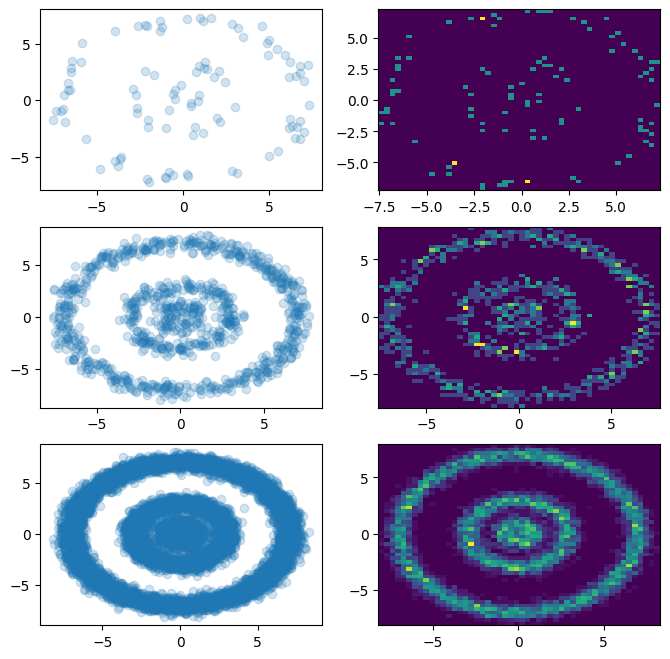

In [644]:
fig, rows = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
for (ax_scat, ax_hist), n in zip(rows, [100, 1_000, 10_000]):
    ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.4)
    ax_scat.scatter(ring_samples[:, 0], ring_samples[:, 1], alpha=0.2)
    ax_hist.hist2d(ring_samples[:, 0], ring_samples[:, 1], bins=(50, 50))

n = 10_000
ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.5)
ring_samples = np.float32(ring_samples)

In [645]:
from cirkit.pipeline import PipelineContext
from cirkit.symbolic.circuit import Circuit
from cirkit.utils.scope import Scope
from cirkit.symbolic.layers import GaussianLayer, HadamardLayer, SumLayer

device = torch.device("cpu")
def new_circuit():

    weight_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='uniform'
    ))
    mean_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='normal',
        initialization_kwargs={"mean": -2, "stddev": 2}
    ))

    g0 = GaussianLayer(Scope((0,)), 2, mean_factory=mean_factory)
    g1 = GaussianLayer(Scope((1,)), 2, mean_factory=mean_factory)
    prod = HadamardLayer(num_input_units=2, arity=2)
    sl = SumLayer(2, 1, 1, weight_factory=weight_factory)

    symbolic_circuit = Circuit(
        layers=[g0, g1, prod, sl],
        in_layers={
            g0: [],
            g1: [],
            prod: [g0, g1],
            sl: [prod],
        },
        outputs=[sl]
    )
    pctx = PipelineContext(backend="torch", semiring="lse-sum", fold=True, optimize=False)
    circuit = compile(symbolic_circuit, pctx)
    circuit = circuit.to(device)
    return symbolic_circuit, circuit

symbolic_circuit, circuit = new_circuit()


Number of variables: 2
Structural properties:
 - Smoothness: True
 - Decomposability: True
 - Structured-decomposability: True
Number of layers: 3
Number of learnable parameters: 10



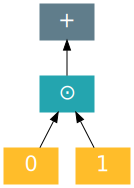

In [646]:
print(f"""
Number of variables: {symbolic_circuit.num_variables}
Structural properties:
 - Smoothness: {symbolic_circuit.is_smooth}
 - Decomposability: {symbolic_circuit.is_decomposable}
 - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}
Number of layers: {len(list(circuit.layers))}
Number of learnable parameters: {sum(p.numel() for p in circuit.parameters())}
""")
plot_circuit(symbolic_circuit)

In [647]:
# from torch import optim
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_fullbatch = []
# time_fullbatch = time.time()
# for epoch_idx in range(1000):
#     batch = ring_samples
#     batch = torch.from_numpy(batch).to(device)
#
#     log_likelihoods = circuit(batch)
#
#     loss = -torch.mean(log_likelihoods)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#
#     LLs_fullbatch.append(-loss.detach())
# time_fullbatch = time.time() - time_fullbatch
#
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_minibatch = []
# time_minibatch = time.time()
# for epoch_idx in range(100):
#     for i, batch in enumerate(np.vsplit(ring_samples, 10)):
#         batch = torch.from_numpy(batch).to(device)
#
#         log_likelihoods = circuit(batch)
#
#         loss = -torch.mean(log_likelihoods)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#         LLs_minibatch.append(-loss.detach())
# time_minibatch = time.time() - time_minibatch
#
# print(f"Full-batch time: {time_fullbatch * 1000:.0f}ms")
# print(f"Minibatch time: {time_minibatch * 1000:.0f}ms")
#
# plt.plot(np.arange(len(LLs_fullbatch)), LLs_fullbatch, label="Full-batch")
# plt.plot(np.arange(len(LLs_minibatch)), LLs_minibatch, label="Minibatch")
# plt.legend()
# plt.show()

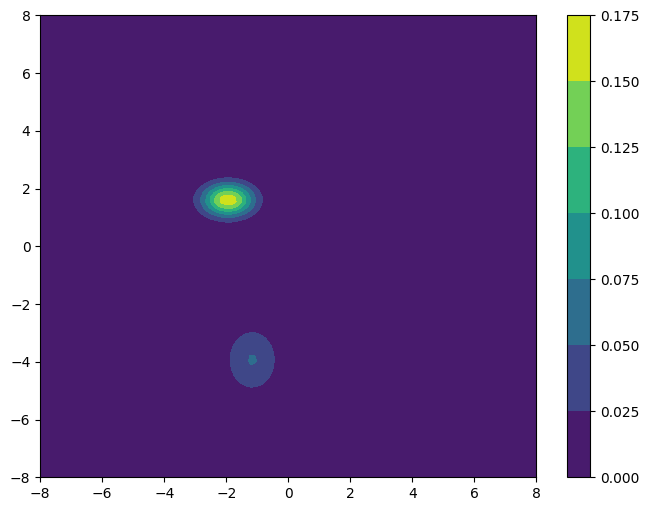

In [648]:
def plot_circuit_distribution_2d(circuit, points=None):
    x = np.float32(np.linspace(-8, 8, 100))
    y = np.float32(np.linspace(-8, 8, 100))

    X, Y = np.meshgrid(x, y)

    xy = itertools.product(x, y)
    xy = torch.tensor(list(xy))
    Z = circuit(xy).detach().exp().numpy().reshape(100, 100)

    plt.figure(figsize=(8,6))
    plt.contourf(X, Y, Z)
    plt.colorbar()

    if points is not None:
        plt.scatter(points[:, 0], points[:, 1], color="red", marker="x")

    plt.show()

plot_circuit_distribution_2d(circuit)

/tmp/ipykernel_4069/3037539356.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.leave_layer_inputs[layer] = torch.tensor(*inputs)
/tmp/ipykernel_4069/3037539356.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inner_layer_inputs[layer] = torch.tensor(*inputs)


tensor([[[0.6368, 0.3632]]])
outputs.shape=torch.Size([2, 4, 2]) outputs_grad.shape=torch.Size([2, 4, 2]) p.shape=torch.Size([2, 4, 2]) x.shape=torch.Size([2, 4, 2]) x_2.shape=torch.Size([2, 4, 2]) 
mu_update=tensor([[ 1.5483, -2.9999],
        [ 1.8301, -3.0000]]) std_update=tensor([[0.5317, 0.0244],
        [0.4319, 0.0100]])


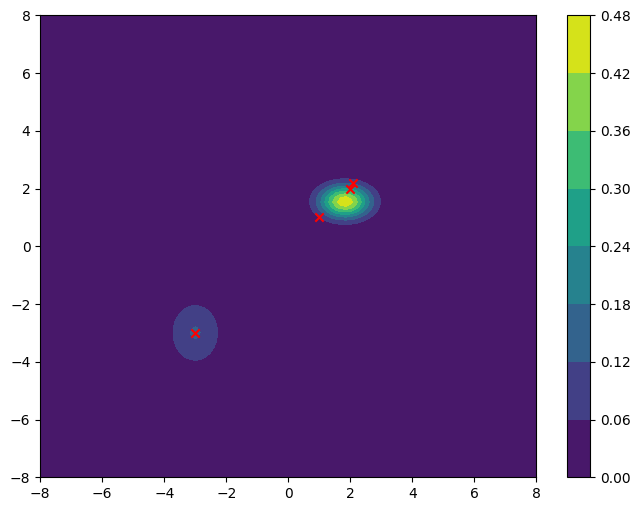

tensor([[[0.5535, 0.4465]]])
outputs.shape=torch.Size([2, 4, 2]) outputs_grad.shape=torch.Size([2, 4, 2]) p.shape=torch.Size([2, 4, 2]) x.shape=torch.Size([2, 4, 2]) x_2.shape=torch.Size([2, 4, 2]) 
mu_update=tensor([[ 1.6649, -3.0000],
        [ 1.4247, -3.0000]]) std_update=tensor([[0.5141, 0.0100],
        [0.5199, 0.0100]])


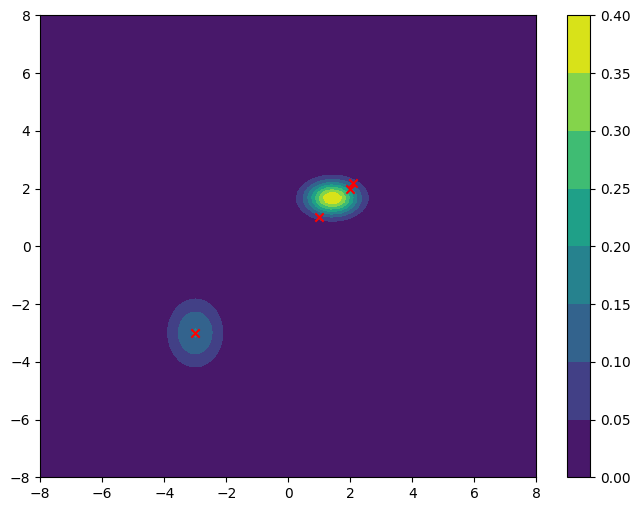

tensor([[[0.4622, 0.5378]]])
outputs.shape=torch.Size([2, 4, 2]) outputs_grad.shape=torch.Size([2, 4, 2]) p.shape=torch.Size([2, 4, 2]) x.shape=torch.Size([2, 4, 2]) x_2.shape=torch.Size([2, 4, 2]) 
mu_update=tensor([[ 1.4220, -3.0000],
        [ 1.8200, -3.0000]]) std_update=tensor([[0.5212, 0.0100],
        [0.4455, 0.0100]])


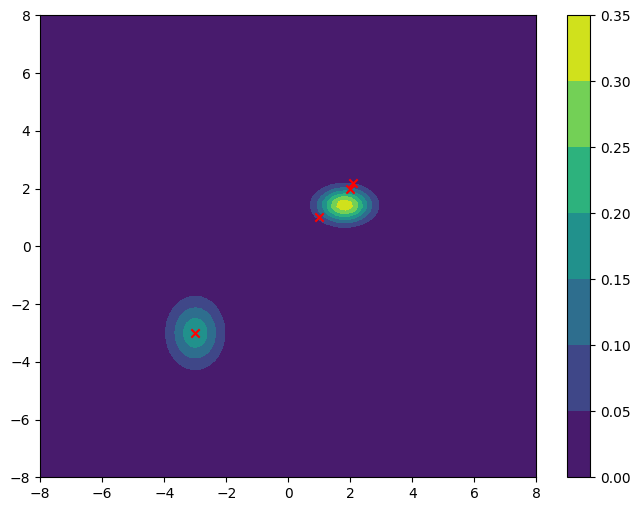

tensor([[[0.3707, 0.6293]]])
outputs.shape=torch.Size([2, 4, 2]) outputs_grad.shape=torch.Size([2, 4, 2]) p.shape=torch.Size([2, 4, 2]) x.shape=torch.Size([2, 4, 2]) x_2.shape=torch.Size([2, 4, 2]) 
mu_update=tensor([[ 1.8683, -3.0000],
        [ 1.4341, -3.0000]]) std_update=tensor([[0.4084, 0.0100],
        [0.5218, 0.0100]])


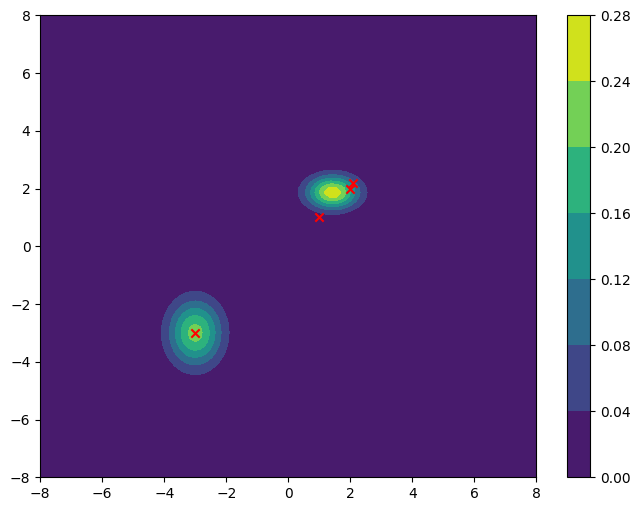

tensor([[[0.3027, 0.6973]]])
outputs.shape=torch.Size([2, 4, 2]) outputs_grad.shape=torch.Size([2, 4, 2]) p.shape=torch.Size([2, 4, 2]) x.shape=torch.Size([2, 4, 2]) x_2.shape=torch.Size([2, 4, 2]) 
mu_update=tensor([[ 1.0745, -3.0000],
        [ 1.8128, -3.0000]]) std_update=tensor([[0.2742, 0.0100],
        [0.4502, 0.0100]])


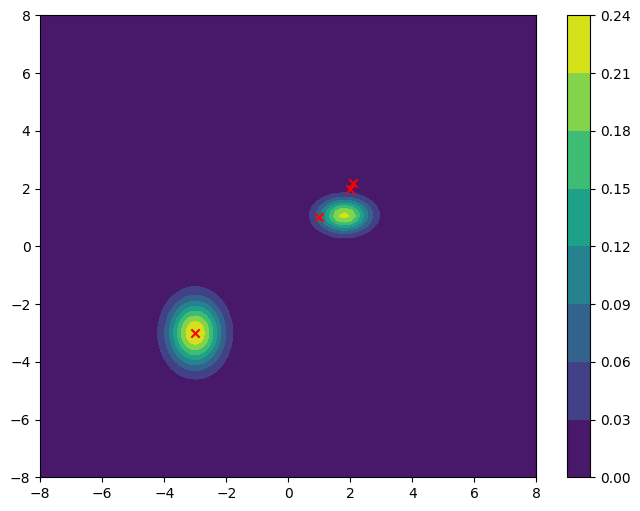

In [649]:
from cirkit.backend.torch.layers import TorchInnerLayer, TorchSumLayer, TorchGaussianLayer


def print_tensor_stats(t):
    print(f"""
    n: {t.numel()}
    elems: {t}
""")

def update_params_nested(params: TorchParameter, new_values: torch.Tensor):
    for p in params.outputs:
        if type(p) == TorchTensorParameter:
            p.update_params(new_values.squeeze())

class FullBatchEM:
    def __init__(self, circuit):
        self.circuit = circuit

        self.inner_layer_params = {}
        self.inner_layer_inputs = {}
        self.inner_layer_outputs = {}

        self.leave_layer_params = {}
        self.leave_layer_inputs = {}
        self.leave_layer_outputs = {}

        for l in circuit.modules():
            if isinstance(l, TorchSumLayer):
                self.inner_layer_params[l] = l.weight
                self.inner_layer_inputs[l] = None
                self.inner_layer_outputs[l] = None
            if isinstance(l, TorchGaussianLayer):
                self.leave_layer_params[l] = l.params
                self.leave_layer_inputs[l] = None
                self.leave_layer_outputs[l] = None


    def _layer_fn(self, layer, *inputs):
        output = layer(*inputs)
        if isinstance(layer, TorchGaussianLayer):
            self.leave_layer_inputs[layer] = torch.tensor(*inputs)
            output.retain_grad()
            self.leave_layer_outputs[layer] = output

        elif isinstance(layer, TorchSumLayer):
            self.inner_layer_inputs[layer] = torch.tensor(*inputs)
            output.retain_grad()
            self.inner_layer_outputs[layer] = output
        return output

    def step_weights(self, S_E):
        for l in self.inner_layer_outputs:
            with torch.no_grad():

                outputs = self.inner_layer_outputs[l]
                outputs_grad = outputs.grad
                inputs = self.inner_layer_inputs[l]
                inputs_grad = inputs.grad
                weight_params = self.inner_layer_params[l]
                weights = weight_params()
                weight_grads = weights.grad


                # print(f"{outputs.shape=} "
                #       f"{inputs.shape=} "
                #       f"{weights.shape=} "
                #       f"{outputs_grad.shape=} ")

                n = (1 / S_E) * outputs_grad * weights * inputs
                n = n.sum(dim=2)
                n_update = n / n.sum()

                # print(f"{n.shape=} {n_update.shape=}")

                # print(f"{weights=}")
                # print(f"{n=}")
                # print(f"{n_update=}")

                print(f"{n_update}")

                weight_params.outputs[0].update_params(n_update)

    def step_leaves(self, S_E, data_full):
        # Initialize the accumulated statistics for the batch
        # This should typically be done outside the batch loop and reset for each EM iteration
        # We will simulate the accumulation here:

        # 1. E-STEP ACCUMULATION (Iterate through all Gaussian layers)
        new_mus = []
        for leaf in self.leave_layer_params:
            with torch.no_grad():
                outputs = self.leave_layer_outputs[leaf]
                outputs_grad = outputs.grad

                x = data_full[:,leaf.scope_idx].squeeze()
                x_2 = x ** 2

                p = outputs * outputs_grad

                x = p * x
                x_2 = p * x_2

                print(f"{outputs.shape=} "
                      f"{outputs_grad.shape=} "
                      f"{p.shape=} "
                      f"{x.shape=} "
                      f"{x_2.shape=} ")

                n_layer = torch.sum(p, dim=1)
                mean = torch.sum(x, dim=1) / n_layer
                var = torch.sum(x_2, dim=1) / n_layer - mean**2

                mu_update = mean
                std_update = torch.sqrt(var)

                # TODO: remove this, only for debugging with single sample
                std_update = torch.clamp(std_update, min=0.01)

                # print(f"{outputs.shape=} "
                #       f"{outputs_grad.shape=} "
                #       f"{p.shape=} "
                #       f"{mu_update.shape=} "
                #       f"{std_update=} "
                #       f"{l.params["mean"].shape} "
                #       f"{l.params['stddev'].shape} ")

                update_params_nested(leaf.params["mean"], mu_update)
                update_params_nested(leaf.params["stddev"], std_update)

                print(f"{mu_update=} {std_update=}")


    def step(self, data):
        S_E = self.circuit.evaluate(data, module_fn=self._layer_fn)
        S_E = S_E.mean()
        S_E.backward()
        self.step_weights(S_E)
        return self.step_leaves(S_E, data)

em = FullBatchEM(circuit)
for i in range(5):
    # em.e_step(torch.from_numpy(ring_samples))
    data = torch.tensor([[1.0, 1.0], [2.0, 2.0], [2.1, 2.2], [-3, -3]])
    # data = torch.tensor([[1.0, 1.0]])
    em.step(data)
    plot_circuit_distribution_2d(circuit, data)


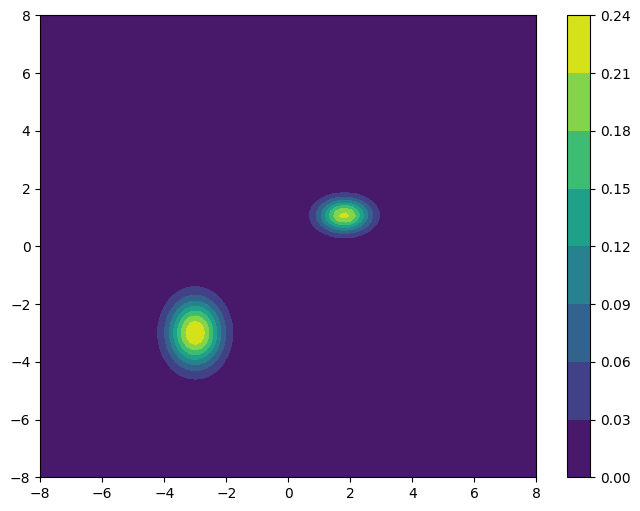

In [650]:
x = np.float32(np.linspace(-8, 8, 100))
y = np.float32(np.linspace(-8, 8, 100))

X, Y = np.meshgrid(x, y)

xy = itertools.product(x, y)
xy = torch.tensor(list(xy))
Z = circuit(xy).detach().exp().numpy().reshape(100, 100)

plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z)
plt.colorbar();

In [651]:
print("Circuit training mode:", circuit.training)
for name, param in circuit.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Circuit training mode: True
_nodes.0.mean._nodes.0._ptensor: requires_grad=True
_nodes.0.stddev._nodes.0._ptensor: requires_grad=True
_nodes.2.weight._nodes.0._ptensor: requires_grad=True
